In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import copy
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as LR

import torchvision
import torchvision.transforms as transforms

In [2]:
class NN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(NN, self).__init__()

    def forward(self, x):
        return x
    
    def update(self, u, v, eta=None):
        pass
    
class Adam(nn.Module):
    def __init__(self, param, betas=(0.9, 0.999), eps=1e-8):
        super(Adam, self).__init__()

        self.register_buffer('beta1', torch.tensor(betas[0]))
        self.register_buffer('beta2', torch.tensor(betas[1]))
        self.register_buffer('eps', torch.tensor(eps))

        self.register_buffer('m', torch.zeros_like(param))
        self.register_buffer('v', torch.zeros_like(param))
        self.register_buffer('t', torch.tensor(0.0))

    def forward(self, g):
        self.m = self.beta1 * self.m + (1-self.beta1) * g
        self.v = self.beta2 * self.v + (1-self.beta2) * g**2
        self.t += 1

        m_hat = self.m/(1 - self.beta1**self.t)
        v_hat = self.v/(1 - self.beta2**self.t)

        return m_hat / (torch.sqrt(v_hat) + self.eps)

class IP(nn.Module):
    def __init__(self, layersize, eta=1):
        super(IP, self).__init__()
        self.eta = eta
        
        # Alpha and beta are the ip normalization parameters
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))
        
        self.adjust_a = Adam(self.alpha)
        self.adjust_b = Adam(self.beta)
        
    def forward(self, x):

        # Normalize
        nx = (x-self.beta)/self.alpha

        return  nx
        
    def update(self, u, v, eta=None):

        if (eta is None):
            eta = self.eta
        
        with torch.no_grad():
            Ev = v.mean(0, keepdim=True)
            Euv = (u*v).mean(0, keepdim=True)

        self.alpha = self.alpha + eta*self.adjust_a(2*Euv)
        self.beta = self.beta + eta*self.adjust_b(Ev)
#         for n in self.alpha:
#             for gain in n:
#                 if(gain != abs(gain)):
#                     print("FLAG!")
        
#         self.eta = eta * 0.999


class Net(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(Net, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(28*28, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 28*28)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc3(v2))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        
        return o
    
class CNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(CNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(3*32*32, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 3*32*32)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc3(v2))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        
        return o

In [3]:
def train_deep_model(network, optimization, seed, epochs):
    
    criterion = nn.CrossEntropyLoss()
    torch.manual_seed(seed)
    
    loss_tracker = []
    episode = 1
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        i = 0

        for i, data in enumerate(trainloader):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimization.zero_grad()

            # forward + backward + optimize
            y = network(inputs)
            loss = criterion(y, labels)
            loss.backward()
            optimization.step()

            # update statistics
            running_loss += loss.item()
            i += 0
            
            loss_tracker.append([episode,loss.item()])
            episode += 1
            
        print('[%d] loss: %.3f' %
                      (epoch + 1,running_loss / i))
            
    print("Finished training!\n")
    return(np.transpose(loss_tracker))


def run_mnist_experiment(int_lr, syn_lr, epochs, test_runs):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = Net(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net. Run %d" % (1))
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = Net(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net. Run %d" % (1))
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = Net(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training IP Net. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Standard Model
        torch.manual_seed(seed)
        net = Net(LAYERSIZE, NN, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training Standard Net. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    standard_losses = standard_losses/test_runs

    plt.figure(figsize=(16, 5))
    plt.ylim([-0.1, 3])
#     plt.title("Learning curves for deep networks")
    plt.plot(ip_losses[0], ip_losses[1], label="IP")
    plt.plot(standard_losses[0], standard_losses[1], label="Standard")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def run_cifar_experiment(int_lr, syn_lr, epochs, test_runs):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = CNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net. Run 1")
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = CNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net. Run 1")
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = CNet(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training IP Net. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Standard Model
        torch.manual_seed(seed)
        net = CNet(LAYERSIZE, NN, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training Standard Net. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    standard_losses = standard_losses/test_runs

    plt.figure(figsize=(16, 5))
    plt.ylim([-0.1, 3])
#     plt.title("Learning curves for shallow networks")
    plt.plot(ip_losses[0], ip_losses[1], label="IP")
    plt.plot(standard_losses[0], standard_losses[1], label="Standard")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# MNIST Test

In [4]:
transform = transforms.ToTensor()


trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

batch_size = 200

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print('==>>> total training batch number: {}'.format(len(trainloader)))
print('==>>> total testing batch number: {}'.format(len(testloader)))

==>>> total training batch number: 300
==>>> total testing batch number: 50


Training IP Net. Run 1
[1] loss: 0.357
[2] loss: 0.244
[3] loss: 0.226
[4] loss: 0.226
[5] loss: 0.202
[6] loss: 0.195
[7] loss: 0.185
[8] loss: 0.178
[9] loss: 0.181
[10] loss: 0.174
[11] loss: 0.176
[12] loss: 0.178
[13] loss: 0.162
[14] loss: 0.169
[15] loss: 0.167
[16] loss: 0.164
[17] loss: 0.161
[18] loss: 0.154
[19] loss: 0.148
[20] loss: 0.140
Finished training!

Training Standard Net. Run 1
[1] loss: 0.361
[2] loss: 0.246
[3] loss: 0.237
[4] loss: 0.232
[5] loss: 0.234
[6] loss: 0.222
[7] loss: 0.221
[8] loss: 0.225
[9] loss: 0.224
[10] loss: 0.220
[11] loss: 0.221
[12] loss: 0.225
[13] loss: 0.232
[14] loss: 0.216
[15] loss: 0.225
[16] loss: 0.251
[17] loss: 0.237
[18] loss: 0.225
[19] loss: 0.214
[20] loss: 0.213
Finished training!

Training IP Net. Run 2
[1] loss: 0.390
[2] loss: 0.247
[3] loss: 0.240
[4] loss: 0.220
[5] loss: 0.220
[6] loss: 0.206
[7] loss: 0.208
[8] loss: 0.191
[9] loss: 0.192
[10] loss: 0.178
[11] loss: 0.181
[12] loss: 0.178
[13] loss: 0.179
[14] loss: 

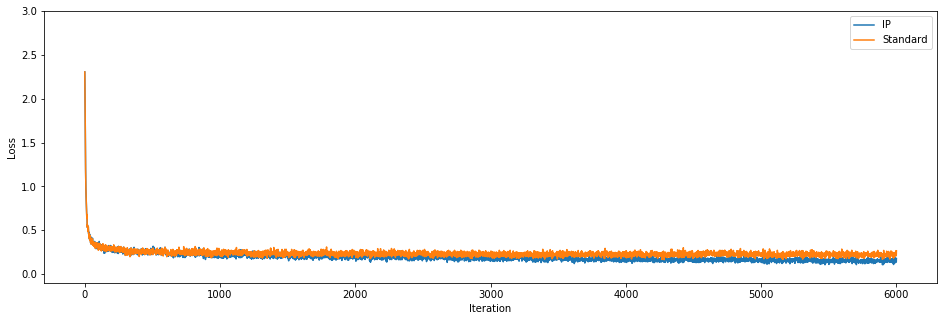

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 50
epochs = 20

test_runs = 10

int_lr = 0.0001
syn_lr = 0.03

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

# CIFAR-10 Test

In [6]:
batchSize = 200

transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Training IP Net. Run 1
[1] loss: 2.121
[2] loss: 1.900
[3] loss: 1.790
[4] loss: 1.739
[5] loss: 1.704
[6] loss: 1.675
[7] loss: 1.650
[8] loss: 1.627
[9] loss: 1.607
[10] loss: 1.592
[11] loss: 1.575
[12] loss: 1.561
[13] loss: 1.549
[14] loss: 1.537
[15] loss: 1.525
[16] loss: 1.515
[17] loss: 1.505
[18] loss: 1.498
[19] loss: 1.487
[20] loss: 1.478
[21] loss: 1.472
[22] loss: 1.466
[23] loss: 1.456
[24] loss: 1.453
[25] loss: 1.445
[26] loss: 1.438
[27] loss: 1.431
[28] loss: 1.425
[29] loss: 1.422
[30] loss: 1.416
[31] loss: 1.413
[32] loss: 1.409
[33] loss: 1.399
[34] loss: 1.395
[35] loss: 1.390
[36] loss: 1.386
[37] loss: 1.386
[38] loss: 1.379
[39] loss: 1.374
[40] loss: 1.369
Finished training!

Training Standard Net. Run 1
[1] loss: 2.134
[2] loss: 1.905
[3] loss: 1.784
[4] loss: 1.727
[5] loss: 1.688
[6] loss: 1.657
[7] loss: 1.626
[8] loss: 1.601
[9] loss: 1.577
[10] loss: 1.558
[11] loss: 1.538
[12] loss: 1.519
[13] loss: 1.503
[14] loss: 1.487
[15] loss: 1.472
[16] loss: 

[18] loss: 1.426
[19] loss: 1.416
[20] loss: 1.402
[21] loss: 1.395
[22] loss: 1.380
[23] loss: 1.369
[24] loss: 1.360
[25] loss: 1.351
[26] loss: 1.341
[27] loss: 1.332
[28] loss: 1.325
[29] loss: 1.310
[30] loss: 1.304
[31] loss: 1.293
[32] loss: 1.289
[33] loss: 1.280
[34] loss: 1.272
[35] loss: 1.263
[36] loss: 1.255
[37] loss: 1.247
[38] loss: 1.237
[39] loss: 1.234
[40] loss: 1.227
Finished training!

Training IP Net. Run 7
[1] loss: 2.086
[2] loss: 1.919
[3] loss: 1.799
[4] loss: 1.749
[5] loss: 1.711
[6] loss: 1.684
[7] loss: 1.658
[8] loss: 1.636
[9] loss: 1.615
[10] loss: 1.601
[11] loss: 1.584
[12] loss: 1.567
[13] loss: 1.556
[14] loss: 1.543
[15] loss: 1.533
[16] loss: 1.522
[17] loss: 1.514
[18] loss: 1.504
[19] loss: 1.497
[20] loss: 1.489
[21] loss: 1.481
[22] loss: 1.476
[23] loss: 1.464
[24] loss: 1.462
[25] loss: 1.456
[26] loss: 1.446
[27] loss: 1.439
[28] loss: 1.432
[29] loss: 1.427
[30] loss: 1.423
[31] loss: 1.417
[32] loss: 1.413
[33] loss: 1.407
[34] loss: 1.4

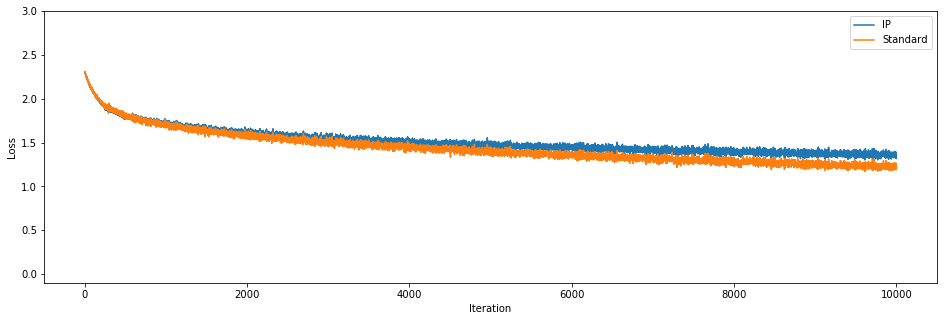

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 150
epochs = 40

test_runs = 10

int_lr = 0.0001
syn_lr = 0.0001

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)